In [1]:
#### Dependencies
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Functions.Preprocess import tracks_to_df
from Functions.Models import train, lstm_mask, cnn
import tensorflow as tf
#### Jupyter notebook flag
nb = True
#### Hard coded parameters
N = 1000  # Total number of events in data
max_ev = 10*N  # Maximum number of events to load (before PT and 2jet cuts)
r = 0.5  # Signal proportion from total events
mult_thresh = 10  # Jet1 multiplicity threshold for initial cut
model_type = cnn
model_name = "cnn"  # Model for classification
bkg_path = ["Data/for_semi_supervised_new/0.{}.5000.0.5.0.50.150.200.root.GetTracks.0.7.txt".format(i) for i in range(50)]
sig_path = ["Data/for_semi_supervised_new/1.{}.5000.0.5.0.50.150.500.root.GetTracks.0.7.txt".format(i) for i in range(50)]
n_constits = 30
mask = 0.0
sort = "PT"
feats = ["track_D0", "track_DZ"] + ["track_PT", "track_Eta", "track_Phi"] 
jet_feats = ["jet_PT", "jet_Eta", "jet_Phi"]
PT_cut = (-1000, 1000)
val_frac = 0.2
analysis_dir = "Analysis/Semi-supervised/"
epochs = 20
#### Inputs
if not nb:
    os.chdir("/gpfs0/kats/users/wunch/dark_jets_repo/")
    analysis_dir = str(sys.argv[1])
    epochs = int(sys.argv[2])
    N = float(sys.argv[3])
    r = float(sys.argv[4])
    os.makedirs(analysis_dir, exist_ok=True)
    bkg_path = ["/gpfs0/kats/users/wunch/cluster_out/bb{}.root.GetTracks.txt".format(i) for i in range(1, 5)]
    sig_path = ["/gpfs0/kats/users/wunch/cluster_out/dark{}.root.GetTracks.txt".format(i) for i in range(1, 5)]

#### Preprocessing
# Load signal and background
bkg_j = tracks_to_df(bkg_path, label=0, max_ev=max_ev, n_constits=n_constits, trunc=False, PT_cut=PT_cut, sort=sort) 
sig_j = tracks_to_df(sig_path, label=1, max_ev=max_ev, n_constits=n_constits, trunc=False, PT_cut=PT_cut, sort=sort)
# Clean single jet events
bkg_evs_2jet = bkg_j.Event.value_counts()[bkg_j.Event.value_counts() > 1].index  # Events with two jets
sig_evs_2jet = sig_j.Event.value_counts()[sig_j.Event.value_counts() > 1].index
print("Number of Background events with two jets is ", len(bkg_evs_2jet), " out of ", len(bkg_j.Event.value_counts())) # Output number of events with two jets
print("Number of Signal events with two jets is ",len(sig_evs_2jet), " out of ", len(sig_j.Event.value_counts()))
print("----------")
bkg_j = bkg_j.loc[bkg_j.Event.map(lambda x: x in bkg_evs_2jet)].reset_index() # Clean single jet events
sig_j = sig_j.loc[sig_j.Event.map(lambda x: x in sig_evs_2jet)].reset_index()
# Group by jet
bkg_j1 = bkg_j[bkg_j.Jet == 1][['Event'] + feats + jet_feats + ['label']]  # Seperate
bkg_j2 = bkg_j[bkg_j.Jet == 2][['Event'] + feats + jet_feats]
bkg_j1 = bkg_j1.rename(columns={feat: feat+"1" for feat in (feats+jet_feats)})  # Rename
bkg_j2 = bkg_j2.rename(columns={feat: feat+"2" for feat in (feats+jet_feats)})
bkg_ev = pd.merge(bkg_j2, bkg_j1, on='Event')  # Merge
sig_j1 = sig_j[sig_j.Jet == 1][['Event'] + feats + jet_feats + ['label']] # Seperate
sig_j2 = sig_j[sig_j.Jet == 2][['Event'] + feats + jet_feats]
sig_j1 = sig_j1.rename(columns={feat : feat+"1" for feat in (feats+jet_feats)}) # Rename
sig_j2 = sig_j2.rename(columns={feat : feat+"2" for feat in (feats+jet_feats)})
sig_ev = pd.merge(sig_j2, sig_j1, on='Event') # Merge
# Create data sample with specified proportions
data = pd.concat([sig_ev.loc[:int(N*r)], bkg_ev.loc[:int(N*(1-r))]]).sample(frac=1).reset_index()
print("N = ", len(data))
print("#B = ", len(data[(data.label == 0)]))
print("#S = ", len(data[(data.label == 1)]))
print("----------")
#### Seperate events into two groups S' (mult_thres=1) B'(mult_thresh=0) by cutting on jet1 multiplicity
data["j1_mult"] = data.track_PT1.map(lambda x: len(x))
data["j1_mult_cut"] = (data.j1_mult > mult_thresh).astype(np.int)
# Output cut efficiencies
B_tag_SNR = len(data[(data.j1_mult_cut == 0) & (data.label == 1)]) / len(data[(data.j1_mult_cut == 0) & (data.label == 0)])
S_tag_SNR = len(data[(data.j1_mult_cut == 1) & (data.label == 1)]) / len(data[(data.j1_mult_cut == 1) & (data.label == 0)])
print("#B' = ", len(data[(data.j1_mult_cut == 0)]), " with S/B of ", B_tag_SNR)
print("#S' = ", len(data[(data.j1_mult_cut == 1)]), " with S/B of ", S_tag_SNR)
print("Background efficiencey of multiplicity cut is = ", len(data[(data.label == 0) & (data.j1_mult_cut == 1)])/len(data[data.label == 0]))
print("Signal efficiencey of multiplicity cut is = ", len(data[(data.label == 1) & (data.j1_mult_cut == 1)])/len(data[data.label == 1]))
print("----------")
# Preprocessing for NN
data.track_PT2 = data.track_PT2 / data.track_PT2.map(np.max)  # Scale and shift
data.track_Eta2 = (data.track_Eta2 - data.jet_Eta2) * 10
data.track_Phi2 = (data.track_Phi2 - data.jet_Phi2) * 10
data.track_DZ2 = data.track_DZ2 / np.cosh(data.jet_Eta2)
j2_feats_for_nn = np.concatenate(np.array(data[[feat+"2" for feat in feats]]
                                          .applymap(lambda x: np.append(x[:n_constits], [mask] * (n_constits - len(x)))))
                                          .flatten()).reshape((len(data), n_constits, len(feats)))

Number of Background events with two jets is  9267  out of  9981
Number of Signal events with two jets is  9332  out of  9884
----------
N =  1002
#B =  501
#S =  501
----------
#B' =  341  with S/B of  0.5714285714285714
#S' =  661  with S/B of  1.3274647887323943
Background efficiencey of multiplicity cut is =  0.5668662674650699
Signal efficiencey of multiplicity cut is =  0.7524950099800399
----------


In [2]:
data[[feat + "2" for feat in feats]].head()

,track_D02,track_DZ2,track_PT2,track_Eta2,track_Phi2
0,"[-0.0127032, -0.0502641, -0.00603068, 0.137381...","[0.013614717726451215, -0.04546458196260107, -...","[1.0, 0.8195331814772633, 0.5879503597322149, ...","[0.12150000000000105, -0.15309999999999935, 0....","[-0.02006999999999981, 0.27764999999999984, 0...."
1,"[-0.318095, -0.130386, -0.364955, 0.144333, -0...","[0.1223681833579823, 0.5125382952680142, 0.273...","[1.0, 0.08232113751109817, 0.06251673005313862...","[0.07800000000000029, -0.40240000000000054, 0....","[-0.31320000000000014, -0.2534000000000014, -1..."
2,"[-0.0176417, 0.000309835, 0.0214445, 0.0385926...","[0.013187658911069903, -0.014664994906538439, ...","[1.0, 0.5691823522957377, 0.5086243528742855, ...","[-0.9000399999999997, 1.0026000000000002, 0.92...","[-0.36966000000000054, -0.8170699999999997, -1..."
3,"[0.00439138, -0.0611179, -0.000355016, -0.0690...","[-0.011819582392492547, -0.08929304326020214, ...","[1.0, 0.3313561744835161, 0.2902697903970869, ...","[1.451880000000001, 0.7271100000000008, -1.424...","[-0.06394999999999929, 0.0022900000000003473, ..."
4,"[-0.616415, -0.169709, 1.56972, 0.757873, -0.2...","[0.3087114918549048, 0.09981391257536122, -0.0...","[1.0, 0.39295274493251714, 0.16732227968054156...","[-0.21809999999999885, -0.12159999999999727, -...","[-0.8212999999999981, -0.5772999999999984, 0.1..."


c:\users\noamw\desktop\jet_tagging\venv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


Wall time: 353 ms


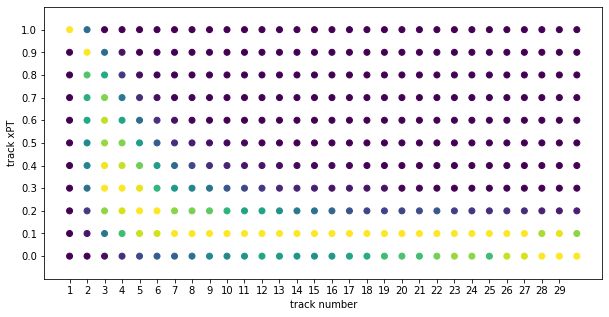

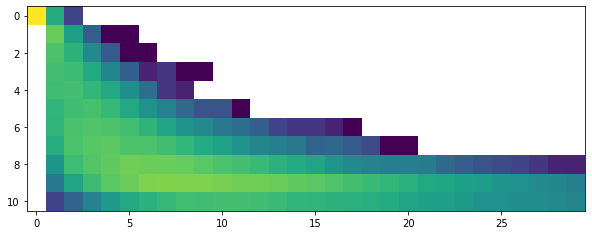

In [27]:
%%time
im = []
plt.close('all')
data[[feat+"2" for feat in feats]] = data[[feat+"2" for feat in feats]].applymap(lambda x: np.append(x[:n_constits], [np.nan] * (n_constits - len(x))))
plt.figure()
for i in range(n_constits):
    counts, bins = np.histogram(data.track_PT2.map(lambda x: x[i]), bins=np.arange(-0.05,1.1,0.1))
    plt.scatter(y=bins[:-1]+(bins[1]-bins[0])/2, x=(i+1)*np.ones(counts.shape), c=counts)
    im.append(np.log(counts))
plt.ylim(-0.1, 1.1)    
plt.xticks(np.arange(1, n_constits))
plt.xlabel('track number')
plt.yticks(bins[:-1]+(bins[1]-bins[0])/2)
plt.ylabel('track xPT')
plt.gcf().set_size_inches(10, 5)
plt.figure()
plt.imshow(np.flipud(np.transpose(im)))
plt.gcf().set_size_inches(10, 10)

c:\users\noamw\desktop\jet_tagging\venv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Wall time: 278 ms


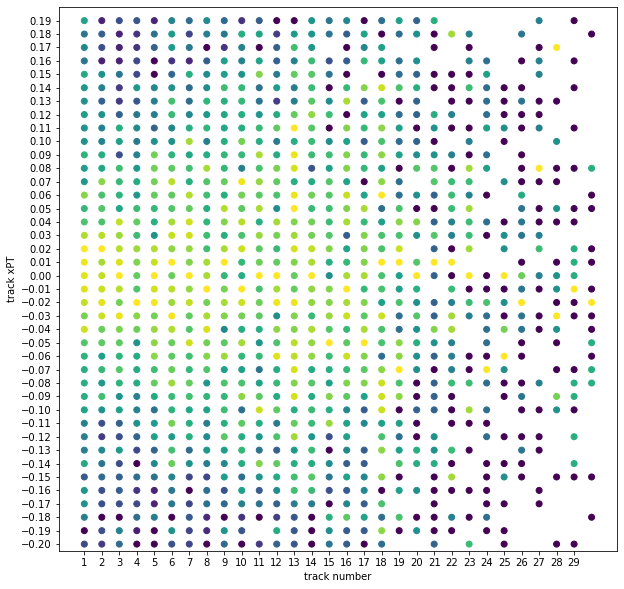

In [14]:
%%time
feature = 'track_DZ2'
plt.close('all')
plt.figure()
im = []
for i in range(n_constits):
    counts, bins = np.histogram(data[feature].map(lambda x: x[i]), bins=np.arange(-0.205, 0.2, 0.01))
    counts = np.log(counts/sum(counts))
    plt.scatter(y=bins[:-1]+(bins[1]-bins[0])/2, x=(i+1)*np.ones(counts.shape), c=counts)
    im.append(counts)
plt.ylim(-0.205, 0.2)    
plt.xticks(np.arange(1, n_constits))
plt.xlabel('track number')
plt.yticks(bins[:-1]+(bins[1]-bins[0])/2)
plt.ylabel('track xPT')
plt.gcf().set_size_inches(10, 10)

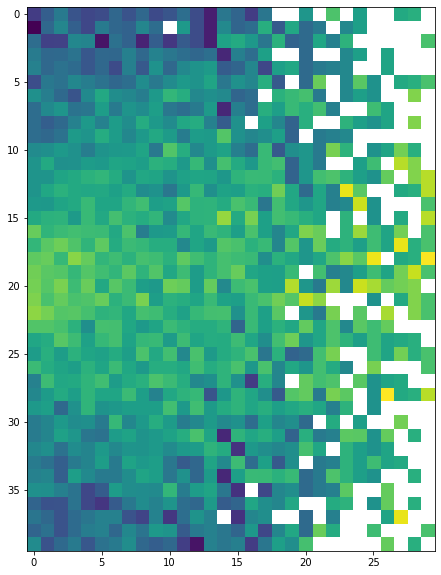

In [19]:
plt.imshow(np.transpose(im))
plt.gcf().set_size_inches(10, 10)

In [102]:
plt.figure()
data[feature].map(lambda x: x[0]).hist(bins=np.arange(-1.05, 1, 0.1), density=True)
data[feature].map(lambda x: x[3]).hist(bins=np.arange(-1.05, 1, 0.1), density=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [107]:
data.iloc[1][feature]

array([ 2.60629 ,  1.4228  , -3.073186, -2.813427, -1.1396  , -1.33532 ,
        0.57172 , -0.23688 , -5.79012 , -0.75833 ,  4.57852 , -5.11203 ,
        1.8963  , -2.479776, -0.76362 , -0.15143 , -3.386963, -0.32082 ,
        0.20733 , -0.05846 ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ])

# Testing 1

In [ ]:
data.head()

In [12]:
data["j2_mult"] = data.track_PT2.map(lambda x: len(x))

In [16]:
label = 1
plt.figure()
data[data.label==label]['j1_mult'].hist(bins=np.arange(0.5, 45, 1), color='black', histtype="step", hatch="x")
data[data.label==label]['j2_mult'].hist(bins=np.arange(0.5, 45, 1), color='red', histtype="step", hatch="o")
plt.gcf().set_size_inches(10, 10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

count    50001.000000
mean       172.464462
std         29.017626
min         67.825000
25%        153.934000
50%        169.832000
75%        188.730000
max        384.439000
Name: jet_PT1, dtype: float64
count    50001.000000
mean       135.101447
std         28.712221
min         24.883500
25%        116.403000
50%        136.639000
75%        154.449000
max        280.904000
Name: jet_PT2, dtype: float64


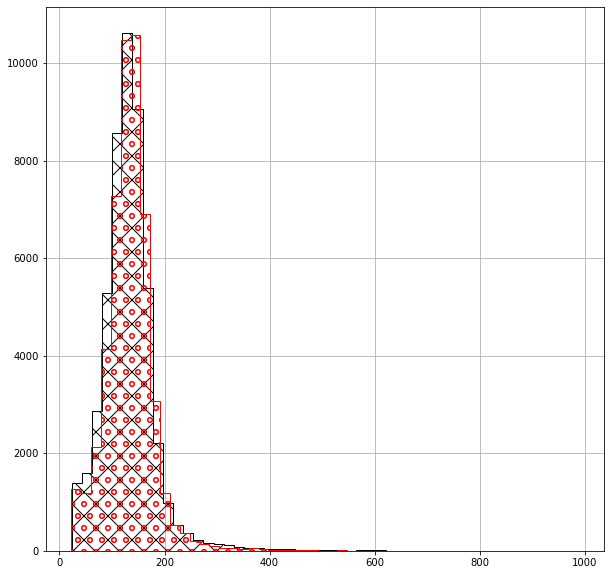

In [5]:
label = 1
data[data.label==label]['jet_PT1'].hist(color='black', histtype="step", hatch="x", bins=50)
data[data.label==label]['jet_PT2'].hist(color='red', histtype="step", hatch="o", bins=50)
plt.gcf().set_size_inches(10, 10)
print(data[data.label==0]['jet_PT1'].describe())
print(data[data.label==0]['jet_PT2'].describe())

count    22730.00000
mean       189.08349
std         24.63192
min        150.15500
25%        171.56600
50%        184.84150
75%        200.80200
max        448.05200
Name: jet_PT1, dtype: float64
count    19746.000000
mean       361.630418
std        170.148265
min        150.003000
25%        226.727000
50%        315.767500
75%        457.908500
max        999.279000
Name: jet_PT1, dtype: float64


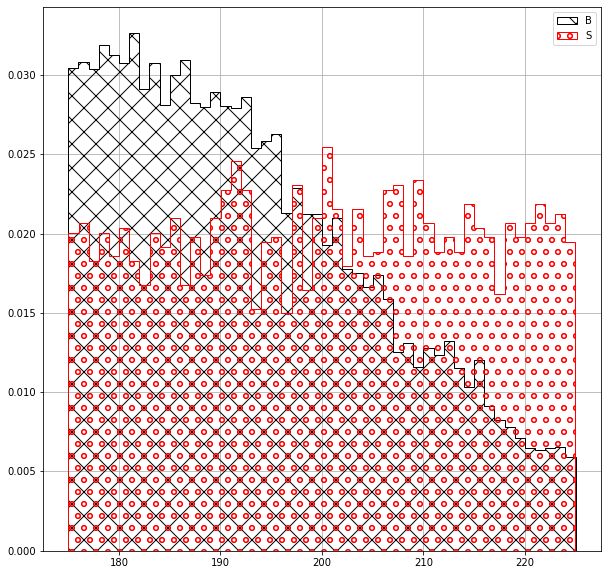

In [25]:
PT_range = (175, 225)
data[data.label==0]['jet_PT1'][data[data.label==0].jet_PT1.between(*PT_range)].hist(color='black', histtype="step", hatch="x", bins=50, density=True)
data[data.label==1]['jet_PT1'][data[data.label==1].jet_PT1.between(*PT_range)].hist(color='red', histtype="step", hatch="o", bins=50, density=True)
plt.gcf().set_size_inches(10, 10)
print(data[data.label==0]['jet_PT1'].describe())
print(data[data.label==1]['jet_PT1'].describe())
plt.legend(['B', 'S'])

Text(0.5, 0, 'j1_mult')

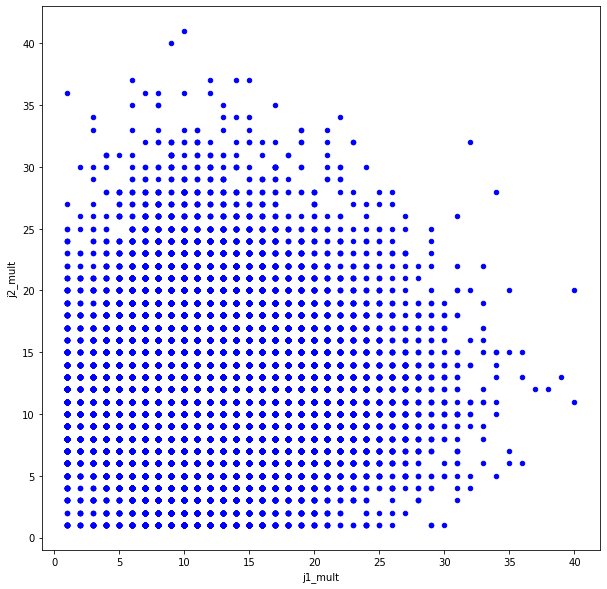

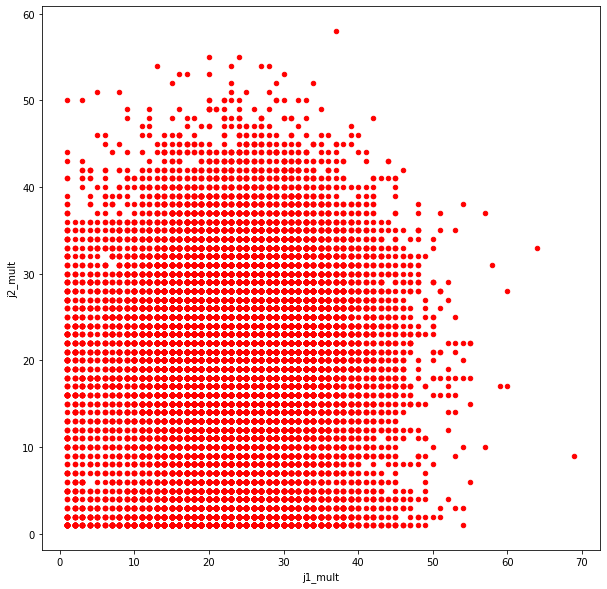

In [26]:
data[data.label==0].plot.scatter('j1_mult', 'j2_mult', c='blue');
plt.gcf().set_size_inches(10, 10)
plt.xlabel('j1_mult')
data[data.label==1].plot.scatter('j1_mult', 'j2_mult', c='red');
plt.gcf().set_size_inches(10, 10)
plt.xlabel('j1_mult')

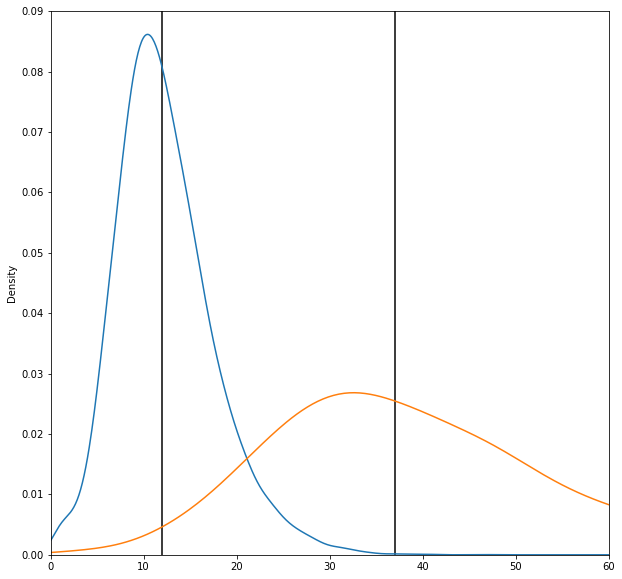

In [35]:
PT_range = (175, 225)
b_inrange_idxs = data[data.label==0].jet_PT1.between(*PT_range).index
s_inrange_idxs = data[data.label==1].jet_PT1.between(*PT_range).index
data.loc[b_inrange_idxs].j1_mult.plot.kde(bw_method=0.2)
data.loc[s_inrange_idxs].j1_mult.plot.kde(bw_method=0.2)
median_bkg = data[data.label==0].j1_mult.median()
median_sig = data[data.label==1].j1_mult.median()
plt.vlines(median_bkg, plt.ylim()[0], plt.ylim()[1], colors='black')
plt.vlines(median_sig, plt.ylim()[0], plt.ylim()[1], colors='black')
plt.xlim([0,60])
plt.ylim([0,0.09])
plt.gcf().set_size_inches(10, 10)

0.04817510603759753


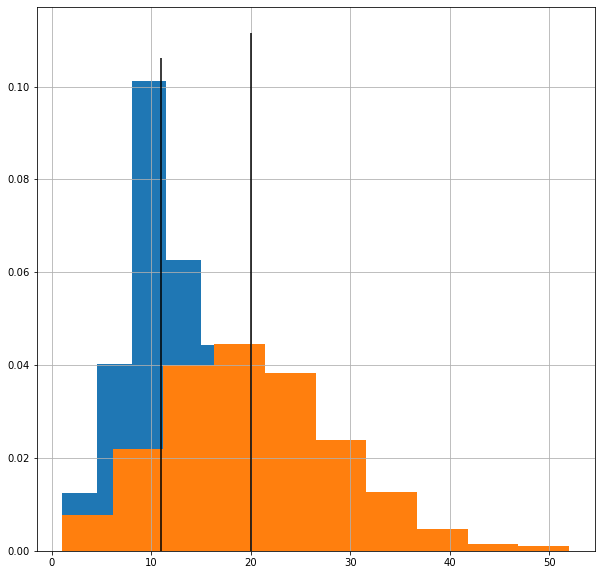

In [71]:
PT_range = (150, 175)
b_inrange_bool = (data.label==0) & (data.jet_PT1.between(*PT_range))
s_inrange_bool = (data.label==1) & (data.jet_PT1.between(*PT_range))
data[b_inrange_bool].j1_mult.hist(density=True)
data[s_inrange_bool].j1_mult.hist(density=True)
median_bkg = data[b_inrange_bool].j1_mult.median()
median_sig = data[s_inrange_bool].j1_mult.median()
plt.vlines(median_bkg, plt.ylim()[0], plt.ylim()[1], colors='black')
plt.vlines(median_sig, plt.ylim()[0], plt.ylim()[1], colors='black')
plt.gcf().set_size_inches(10, 10)
print(sum(data[b_inrange_bool].j1_mult>median_sig)/sum(b_inrange_bool))

In [48]:
len(data.iloc[b_inrange_idxs])

22730

In [29]:
len(b_inrange_idxs)

22730

In [31]:
b_inrange_idxs

3        False
4         True
6         True
7        False
10       False
         ...  
42469     True
42470    False
42473     True
42474     True
42475     True
Name: jet_PT1, Length: 22730, dtype: bool

In [30]:
len(data)

42476

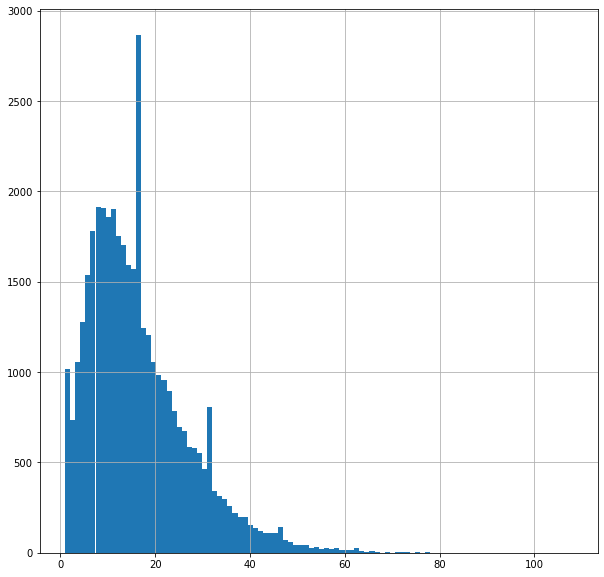

In [11]:
data[data.label==1].j1_mult.hist(bins=100)
plt.gcf().set_size_inches(10, 10)

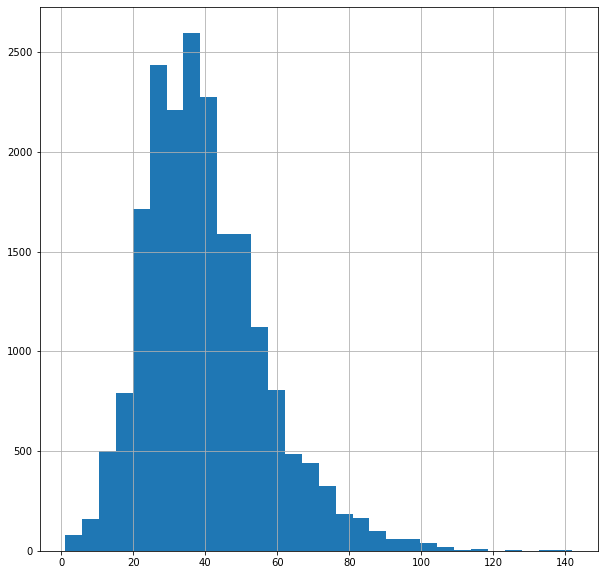

In [21]:
data[data.label==1].j1_mult.hist(bins=30)
plt.gcf().set_size_inches(10, 10)

In [17]:
len(data[data.label==1])

40696

In [82]:
print(data[data.label==0][['j1_mult', 'j2_mult']].corr())
print(data[data.label==1][['j1_mult', 'j2_mult']].corr())
print(data[data.label==1][['j1_mult', 'jet_PT2']].corr())
print(data[data.label==1][['j1_mult', 'jet_Eta2']].corr())
print(data[['j1_mult', 'j1_mult_cut']].corr())
print(data[['j1_mult', 'j2_mult']].corr())

          j1_mult   j2_mult
j1_mult  1.000000  0.021886
j2_mult  0.021886  1.000000
          j1_mult   j2_mult
j1_mult  1.000000  0.042092
j2_mult  0.042092  1.000000
          j1_mult   jet_PT2
j1_mult  1.000000  0.058675
jet_PT2  0.058675  1.000000
           j1_mult  jet_Eta2
j1_mult   1.000000 -0.003864
jet_Eta2 -0.003864  1.000000
              j1_mult  j1_mult_cut
j1_mult      1.000000     0.655524
j1_mult_cut  0.655524     1.000000
          j1_mult   j2_mult
j1_mult  1.000000  0.356437
j2_mult  0.356437  1.000000


In [80]:
data[['j1_mult', 'j2_mult']].corr()

,j1_mult,j2_mult
j1_mult,1.000000,0.356437
j2_mult,0.356437,1.000000


count    92187.000000
mean        15.389751
std          8.614306
min          1.000000
25%          9.000000
50%         14.000000
75%         21.000000
max         58.000000
Name: j2_mult, dtype: float64

In [70]:
x

,jet_PT1,jet_PT2
jet_PT1,1.000000,0.265583
jet_PT2,0.265583,1.000000


In [18]:
plt.close('all')

# Training

In [24]:
%%time
### Train classifier to distinguish between S' anb B' using jet2 features
train_ind = np.arange(0, int(len(data) * (1 - val_frac)))
val_ind = np.arange(int(len(data) * (1 - val_frac)), len(data))
X_train = j2_feats_for_nn[train_ind]
X_val = j2_feats_for_nn[val_ind]
y_train = data.iloc[train_ind]["j1_mult_cut"]
y_val = data.loc[val_ind]["j1_mult_cut"]
# Train
model = model_type(n_constits, feats)
train(model, X_train, y_train, X_val, y_val, model_name, epochs=epochs)
#### Seperate data into two groups S_pred B_pred by cutting on jet2 classification output
model = tf.keras.models.load_model("Models/"+model_name)
data["nn_out"] = model.predict(j2_feats_for_nn).flatten()
# Second classifier ROC curve
plt.figure()
bkg_eff = []
sig_eff = []
closest_half_sig_eff = 0
bkg_eff_closest_half_sig_eff = 0
for nn_thresh in np.arange(0, 1, 0.1):
    bkg_eff_temp = len(data[(data.label == 0) & (data.nn_out>nn_thresh)])/len(data[data.label == 0])
    sig_eff_temp = len(data[(data.label == 1) & (data.nn_out>nn_thresh)])/len(data[data.label == 1])
    bkg_eff.append(bkg_eff_temp)
    sig_eff.append(sig_eff_temp)
    if abs(sig_eff_temp - 0.5) < abs(closest_half_sig_eff - 0.5):
        closest_half_sig_eff = sig_eff_temp
        bkg_eff_closest_half_sig_eff = bkg_eff_temp
plt.plot(bkg_eff, sig_eff, '--k')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.annotate('NN bkg rejection @{:.3} sig efficiency = {:.2e}'.format(closest_half_sig_eff, bkg_eff_closest_half_sig_eff), xy=(0.01, 0.95), xycoords='axes fraction')
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.gcf().set_size_inches(8.3, 5.85)
plt.savefig(analysis_dir + "cnn_ROC_" + model_name + ".pdf", format="pdf")
plt.savefig(analysis_dir + "cnn_ROC_" + model_name + ".svg", format="svg")
# Multiplicity cut ROC curve
bkg_eff = []
sig_eff = []
closest_half_sig_eff = 0
bkg_eff_closest_half_sig_eff = 0
for mult_threshold in np.arange(1, 50):
    bkg_eff_temp = len(data[(data.label == 0) & (data.j1_mult > mult_threshold)])/len(data[data.label == 0])
    sig_eff_temp = len(data[(data.label == 1) & (data.j1_mult > mult_threshold)])/len(data[data.label == 1])
    bkg_eff.append(bkg_eff_temp)
    sig_eff.append(sig_eff_temp)
    if abs(sig_eff_temp - 0.5) < abs(closest_half_sig_eff - 0.5):
        closest_half_sig_eff = sig_eff_temp
        bkg_eff_closest_half_sig_eff = bkg_eff_temp
plt.plot(bkg_eff, sig_eff, '-r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.annotate('Mult cut bkg rejection @{:.3} sig efficiency = {:.2e}'.format(closest_half_sig_eff, bkg_eff_closest_half_sig_eff), xy=(0.01, 0.88), xycoords='axes fraction')
plt.ylabel("Signal efficiency")
plt.xlabel("Background efficiency")
plt.legend(["NN", "Multiplicity cut"], loc='lower left')
plt.gcf().set_size_inches(8.3, 5.85)
plt.savefig(analysis_dir + "multcut_ROC_" + model_name + ".pdf", format="pdf")
plt.savefig(analysis_dir + "multcut_ROC_" + model_name + ".svg", format="svg")
# NN output vs multiplicity cut histograms
plt.figure()
data[(data.label == 1)].nn_out.hist(range=[0, 1], color='black', histtype="step", hatch="x", density=True)
data[(data.label == 0)].nn_out.hist(range=[0, 1], color='red', histtype="step", hatch="o", density=True)
(data[(data.label == 1)].j1_mult/(data[(data.label == 1)].j1_mult).max()).hist(range=[0, 1], color='green', histtype="step", hatch="x", density=True)
(data[(data.label == 0)].j1_mult/(data[(data.label == 1)].j1_mult).max()).hist(range=[0, 1], color='blue', histtype="step", hatch="o", density=True)
plt.legend(["Signal - NN", "Background - NN", "Signal - multiplicity cut", "Background - multiplicity cut"])
plt.savefig(analysis_dir + "seperation_hist_" + model_name + ".pdf", format="pdf")
plt.gcf().set_size_inches(8.3, 5.85)

# NN vs multiplicity correlation
#data.plot.scatter('nn_out', 'j1_mult', c='blue');
#plt.gcf().set_size_inches(8.3, 5.85)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 30, 128)           2048      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 30, 64)            24640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 15, 32)            6176      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 32)           

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Wall time: 4min 33s


In [23]:
plt.figure()
(data[(data.label == 1)].j1_mult/(data[(data.label == 1)].j1_mult).max()).hist(range=[0, 1], color='green', histtype="step", hatch="x", density=True)
(data[(data.label == 0)].j1_mult/(data[(data.label == 1)].j1_mult).max()).hist(range=[0, 1], color='blue', histtype="step", hatch="o", density=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [5]:
data['j2_mult'] = data.track_PT2.map(lambda x: len(x))
print(data[['nn_out', 'j1_mult']].corr())
print(data[['nn_out', 'j2_mult']].corr())
print(data[['j1_mult', 'j2_mult']].corr())

           nn_out   j1_mult
nn_out   1.000000  0.370797
j1_mult  0.370797  1.000000
           nn_out   j2_mult
nn_out   1.000000  0.758352
j2_mult  0.758352  1.000000
         j1_mult  j2_mult
j1_mult  1.00000  0.31658
j2_mult  0.31658  1.00000


# Testing 2

In [58]:
data[['j1_mult_cut', 'nn_out']].corr()

,j1_mult_cut,nn_out
j1_mult_cut,1.000000,0.478089
nn_out,0.478089,1.000000


In [65]:
data.nn_out.describe()

count    92187.000000
mean         0.313635
std          0.233325
min          0.000089
25%          0.088528
50%          0.229352
75%          0.579093
max          0.805789
Name: nn_out, dtype: float64

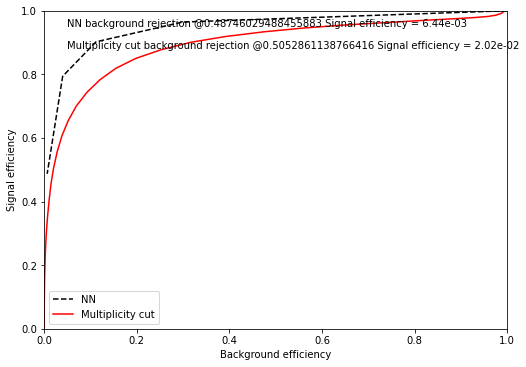

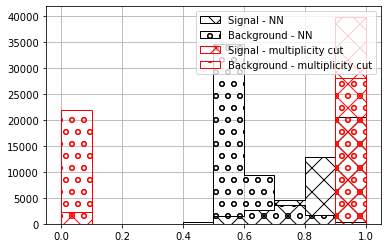

In [77]:
# Second classifier ROC curve
plt.figure()
bkg_eff = []
sig_eff = []
closest_half_sig_eff = 0
bkg_eff_closest_half_sig_eff = 0
for nn_thresh in np.arange(0, 1, 0.1):
    bkg_eff_temp = len(data[(data.label == 0) & (data.nn_out>nn_thresh)])/len(data[data.label == 0])
    sig_eff_temp = len(data[(data.label == 1) & (data.nn_out>nn_thresh)])/len(data[data.label == 1])
    bkg_eff.append(bkg_eff_temp)
    sig_eff.append(sig_eff_temp)
    if abs(sig_eff_temp - 0.5) < abs(closest_half_sig_eff - 0.5):
        closest_half_sig_eff = sig_eff_temp
        bkg_eff_closest_half_sig_eff = bkg_eff_temp
plt.plot(bkg_eff, sig_eff, '--k')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.annotate('NN background rejection @{} Signal efficiency = {:.2e}'.format(closest_half_sig_eff, bkg_eff_closest_half_sig_eff), xy=(0.05, 0.95), xycoords='axes fraction')
plt.ylabel("Signal efficiency")
plt.xlabel("Background efficiency")
plt.gcf().set_size_inches(8.3, 5.85)
plt.savefig(analysis_dir + "cnn_ROC_" + model_name + ".pdf", format="pdf")
plt.savefig(analysis_dir + "cnn_ROC_" + model_name + ".svg", format="svg")
# Multiplicity cut ROC curve
bkg_eff = []
sig_eff = []
closest_half_sig_eff = 0
bkg_eff_closest_half_sig_eff = 0
for mult_threshold in np.arange(1, 50):
    bkg_eff_temp = len(data[(data.label == 0) & (data.j1_mult > mult_threshold)])/len(data[data.label == 0])
    sig_eff_temp = len(data[(data.label == 1) & (data.j1_mult > mult_threshold)])/len(data[data.label == 1])
    bkg_eff.append(bkg_eff_temp)
    sig_eff.append(sig_eff_temp)
    if abs(sig_eff_temp - 0.5) < abs(closest_half_sig_eff - 0.5):
        closest_half_sig_eff = sig_eff_temp
        bkg_eff_closest_half_sig_eff = bkg_eff_temp
plt.plot(bkg_eff, sig_eff, '-r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.annotate('Multiplicity cut background rejection @{} Signal efficiency = {:.2e}'.format(closest_half_sig_eff, bkg_eff_closest_half_sig_eff), xy=(0.05, 0.88), xycoords='axes fraction')
plt.ylabel("Signal efficiency")
plt.xlabel("Background efficiency")
plt.legend(["NN", "Multiplicity cut"])
plt.gcf().set_size_inches(8.3, 5.85)
plt.savefig(analysis_dir + "multcut_ROC_" + model_name + ".pdf", format="pdf")
plt.savefig(analysis_dir + "multcut_ROC_" + model_name + ".svg", format="svg")
# NN output vs multiplicity cut histograms
plt.figure()
data[(data.label == 1)].nn_out.hist(range=[0, 1], color='black', histtype="step", hatch="x")
data[(data.label == 0)].nn_out.hist(range=[0, 1], color='black', histtype="step", hatch="o")
data[(data.label == 1)].j1_mult_cut.hist(range=[0, 1], color='red', histtype="step", hatch="x")
data[(data.label == 0)].j1_mult_cut.hist(range=[0, 1], color='red', histtype="step", hatch="o")
plt.legend(["Signal - NN", "Background - NN", "Signal - multiplicity cut", "Background - multiplicity cut"])
plt.savefig(analysis_dir + "seperation_hist_" + model_name + ".pdf", format="pdf")